# Analysis Using Masked Data

### Import Modules and DEM

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
from scipy.stats import gaussian_kde
import numpy.ma as ma
import math

KeyboardInterrupt: 

In [ ]:
dem=xr.open_dataset('/g/data/dt55/wil_outputs/dem_aus.nc')
source_ds=dem.rename_vars({'ASCIITo_asc1':'dem'})
#source_ds.dem.plot()

In [ ]:
startd = "2020-01-01T00:00"
endd = "2020-12-31T23:00"

In [ ]:
from dask.distributed import Client, LocalCluster

In [ ]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,memory="32GB",walltime='06:00:00')
client = Client(cluster)

In [ ]:
#cluster.adapt(min=24,max=256)
cluster.scale(cores=16)

In [ ]:
cluster

In [ ]:
client.restart()

## Change Input

In [9]:
 df=pd.read_csv('/g/data/dt55/jm1356/data/T15_pix_mean.csv',parse_dates=True)
#df.valid_time
#** pd.to_datetime(df.valid_time)

In [10]:
freq = '10T'
files_date = pd.to_datetime(df.iloc[:,1])
sample_data = '/g/data/dt55/rainfields/prcp-m60/310'
full_list_files = sample_data + files_date.dt.strftime("/%Y/%m/%d/*%Y%m%d_%H%M00*.nc")
###
my_files = []
for fn in full_list_files:
    fn = glob.glob(fn)
    if fn:
        my_files.append(fn[0])

In [11]:
def preprocess_radar(ds):
    if 'valid_time' not in ds.coords:
        ds = ds.assign_coords(
            valid_time=ds.valid_time).expand_dims('valid_time')
    return ds

In [13]:
# open input netcdf
input_radar_ds = xr.open_mfdataset(
    my_files,
    combine='nested',
    concat_dim='valid_time',
    parallel=True,
    lock=False,
    preprocess=preprocess_radar)

In [14]:
## Some useful functions
# Make a Cartopy Projection Object from netcdf Proj info
def get_ccrs_from_proj(ds):
    import cartopy.crs as ccrs
    if 'proj' in ds.variables:
        try:
            return ccrs.AlbersEqualArea(central_longitude=ds.proj.attrs['longitude_of_central_meridian'],
                            central_latitude=ds.proj.attrs['latitude_of_projection_origin'],
                            false_easting=ds.proj.attrs['false_easting'],
                            false_northing=ds.proj.attrs['false_northing'],
                            standard_parallels=ds.proj.attrs['standard_parallel'],
                            globe=None)
        except Exception as err:
            print(err)
            return ccrs.PlateCarree()


# define color table for RF3
class cmap_rf3(object):
    """Define color maps for RF3 rainfall products."""

    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt

    # RAINFALL
    rainfall_colors = np.array([(255, 255, 255),  # 0.0
                                (245, 245, 255),  # 0.2
                                (180, 180, 255),  # 0.5
                                (120, 120, 255),  # 1.5
                                (20,  20, 255),  # 2.5
                                (0, 216, 195),  # 4.0
                                (0, 150, 144),  # 6.0
                                (0, 102, 102),  # 10
                                (255, 255,   0),  # 15
                                (255, 200,   0),  # 20
                                (255, 150,   0),  # 30
                                (255, 100,   0),  # 40
                                (255,   0,   0),  # 50
                                (200,   0,   0),  # 60
                                (120,   0,   0),  # 75
                                (100,   0,   0)])  # > 100
    rainfall_colors = rainfall_colors/255.
    #cm_rainfall = 'blues'
    cm_rainfall = ListedColormap(rainfall_colors, 'blues')
    rainfall_levels = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_hr = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_10min = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]  
    rainfall_levels_m = [0,20,40,60,80,100,120,140,160,180,200,220,240,260]
        
def transform_coords_from_km_to_m(ds):
    """Transform coords from km to m (if required)."""
    if ds is not None:
        if 'x' in ds.coords:
            if 'units' in ds.x.attrs:
                if ds.x.units == 'km':
                    ds['x'] = ds.x*1000.
                    ds.x.attrs.update({'units': 'm'})
                    ds.x.attrs.update(
                        {'standard_name':
                         'projection_x_coordinate'})
                    message = '; Original coords x transformed to m from km'
                    if 'history' in ds.attrs:
                        ds.attrs['history'] += message
                    else:
                        ds.attrs['history'] = message
                if ds.y.units == 'km':
                    ds['y'] = ds.y*1000.
                    ds.y.attrs.update({'units': 'm'})
                    ds.y.attrs.update(
                        {'standard_name':
                         'projection_y_coordinate'})
                    ds.attrs['history'] += '; Original coords y transformed to m from km'
    return ds

def preprocess_radar(ds):
    ds = transform_coords_from_km_to_m(ds)
    if 'n2' in ds.dims:
        ds = ds.drop_dims('n2')
    return ds

def get_projection_from_dataset(rainfall):
    """Return a cartopy projection object from a dataset."""
    try:
        if ('proj' in rainfall.data_vars):
            proj = rainfall.variables['proj']
            if (proj.attrs['grid_mapping_name'] ==
                    "albers_conical_equal_area"):
                projection = ccrs.AlbersEqualArea(
                    central_longitude=proj.attrs['longitude_of_central_meridian'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    standard_parallels=proj.attrs['standard_parallel'],
                    )
            elif (getattr(proj, 'grid_mapping_name') ==
                    "gnomonic"):
                print('Projection is gnomonic')
                projection = ccrs.Gnomonic(
                    central_longitude=proj.attrs['longitude_of_projection_origin'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    )
        else:
            print("INFO: Assuming standard PlateCarree projection")
            projection = ccrs.PlateCarree()
        return projection
    except Exception as err:
        print(err)
        return None

def get_coords_from_dataset(rainfall):
    """Return coordinates in a dataset."""
    try:
        if ('lat' in rainfall.coords):
            x = rainfall['lon'][:].data
            y = rainfall['lat'][:].data
        elif ('x' in rainfall.coords):
            x = rainfall['x'][:].data
            y = rainfall['y'][:].data
            if (rainfall['x'].units == 'km'):
                factor = 1000.
                x = x * factor
                y = y * factor
        else:
            x = np.array(None)
            y = np.array(None)
        return x, y
    except Exception as err:
        print(err)
        return None, None

In [15]:
radar_data=transform_coords_from_km_to_m(input_radar_ds)

## Load File

In [16]:
T15_file='/g/data/dt55/pst/projection/PST_tile_T15-Brisbane_projection.nc'
T15_tile_ds=xr.open_dataset(T15_file)

In [17]:
_, T15_fix = xr.align(T15_tile_ds,radar_data,join='left',)

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.06/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [18]:
T15_acc_raw=T15_fix.sum(['valid_time'])

In [19]:
T15_acc_fil = xr.where(T15_acc_raw<3000,T15_acc_raw,np.nan)
T15_acc = xr.where(0<T15_acc_fil,T15_acc_raw,np.nan)

In [20]:
target_proj = get_projection_from_dataset(T15_fix)

In [21]:
target_x_points, target_y_points = get_coords_from_dataset(T15_fix)
coord_x_grid_target, coord_y_grid_target = np.meshgrid(target_x_points,
                                                           target_y_points)
proj_info = radar_data.proj.copy()

In [22]:
source_proj = get_projection_from_dataset(source_ds)
target_xyz = source_proj.transform_points(target_proj,
                                              coord_x_grid_target,
                                              coord_y_grid_target,
                                              )
# store new coordinates in the source projection
# as DataArray

new_y = xr.DataArray(target_xyz[:, :, 1],
                     dims=["y","x"],
                     coords={"x": target_x_points,"y":target_y_points})
new_x = xr.DataArray(target_xyz[:, :, 0],
                     dims=["y","x"],
                     coords={"x": target_x_points,"y":target_y_points})

INFO: Assuming standard PlateCarree projection


In [23]:
topo = source_ds['dem'].interp(lon=new_x,lat=new_y,method='nearest')

In [24]:
T15_topo =  xr.where(topo < 2300 , topo, np.nan)

In [25]:
topo_levels = [0,200,400,600,800,1000]

## Plotting Map Projection

In [30]:
to_plot=T15_acc.isel(x=slice(220,320),y=slice(60,160))
to_plot

<xarray.Dataset>
Dimensions:        (n2: 2, x: 100, y: 100)
Coordinates:
  * x              (x) float64 1.929e+06 1.931e+06 ... 2.125e+06 2.127e+06
  * y              (y) float64 -3.291e+06 -3.289e+06 ... -3.095e+06 -3.093e+06
Dimensions without coordinates: n2
Data variables:
    proj           float64 nan
    y_bounds       (y, n2) float64 dask.array<chunksize=(100, 2), meta=np.ndarray>
    x_bounds       (x, n2) float64 dask.array<chunksize=(100, 2), meta=np.ndarray>
    precipitation  (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>

In [27]:
to_plot_ones=xr.ones_like(to_plot)
to_plot_ones

<xarray.Dataset>
Dimensions:        (n2: 2, x: 100, y: 100)
Coordinates:
  * x              (x) float64 1.929e+06 1.931e+06 ... 2.125e+06 2.127e+06
  * y              (y) float64 -3.291e+06 -3.289e+06 ... -3.095e+06 -3.093e+06
Dimensions without coordinates: n2
Data variables:
    proj           float64 1.0
    y_bounds       (y, n2) float64 dask.array<chunksize=(100, 2), meta=np.ndarray>
    x_bounds       (x, n2) float64 dask.array<chunksize=(100, 2), meta=np.ndarray>
    precipitation  (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>

Text(0.5, 1.0, 'Brisbane Precipitation Accumulation - 2020')

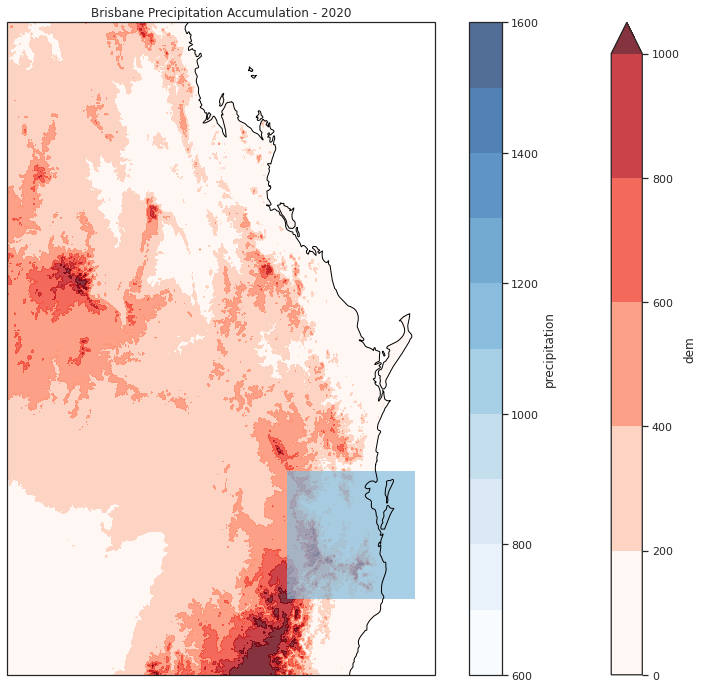

In [61]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj})
T15_topo.plot.contourf(levels=topo_levels,cmap='Reds',add_colorbar=True,ax=ax,add_labels=True,alpha=0.8)
(to_plot_ones.precipitation*1000.).plot(ax=ax,add_colorbar=True,cmap='Blues',
            levels=cmap_rf3.rainfall_levels_hr,alpha=0.7)
ax.coastlines('10m')
ax.set_title('Brisbane Precipitation Accumulation - 2020')

In [31]:
to_plot_topo=T15_topo.isel(x=slice(220,320),y=slice(60,160))
to_plot_topo

<xarray.DataArray 'dem' (y: 100, x: 100)>
array([[ 958.8432,  964.7936, 1031.751 , ...,       nan,       nan,
              nan],
       [ 977.5826,  940.0007,  986.9943, ...,       nan,       nan,
              nan],
       [ 967.4227,  949.3797,  968.2262, ...,       nan,       nan,
              nan],
       ...,
       [ 527.7111,  603.9868,  609.5438, ...,       nan,       nan,
              nan],
       [ 595.0161,  679.2203,  711.3704, ...,       nan,       nan,
              nan],
       [ 611.4351,  614.2487,  592.7289, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
    lon      (y, x) float64 152.1 152.1 152.1 152.2 ... 153.7 153.7 153.8 153.8
    lat      (y, x) float64 -28.89 -28.89 -28.89 -28.88 ... -26.87 -26.86 -26.86
  * x        (x) float64 1.929e+06 1.931e+06 1.933e+06 ... 2.125e+06 2.127e+06
  * y        (y) float64 -3.291e+06 -3.289e+06 ... -3.095e+06 -3.093e+06

Text(0.5, 1.0, 'Brisbane Precipitation Accumulation - 2020')

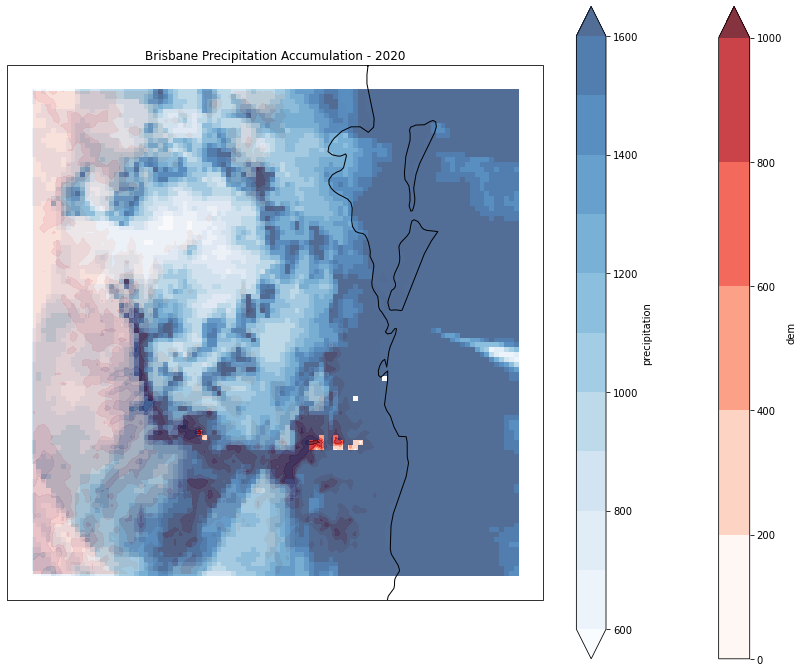

In [31]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj})
to_plot_topo.plot.contourf(levels=topo_levels,cmap='Reds',add_colorbar=True,ax=ax,add_labels=True,alpha=0.8)
to_plot.precipitation.plot(ax=ax,add_colorbar=True,cmap='Blues',
            levels=cmap_rf3.rainfall_levels_hr,alpha=0.7)
ax.coastlines('10m')
ax.set_title('Brisbane Precipitation Accumulation - 2020')

#### Removing Low Elevations

In [35]:
to_plot_mask = xr.where(to_plot_topo  > 0, to_plot.precipitation, np.nan)

In [36]:
to_plot_topo_mask = xr.where(to_plot_topo > 20 , to_plot.precipitation, np.nan)

Text(0.5, 1.0, 'Brisbane Precipitation Accumulation - 2020')

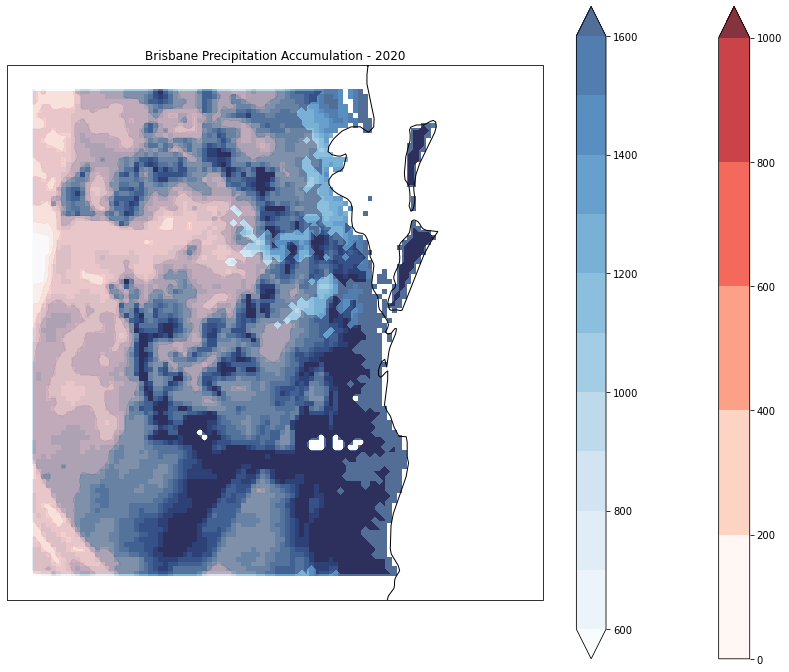

In [37]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj})
to_plot_topo_mask.plot.contourf(levels=topo_levels,cmap='Reds',add_colorbar=True,ax=ax,add_labels=True,alpha=0.8)
to_plot_mask.plot(ax=ax,add_colorbar=True,cmap='Blues',
            levels=cmap_rf3.rainfall_levels_hr,alpha=0.7)
ax.coastlines('10m')
ax.set_title('Brisbane Precipitation Accumulation - 2020')

## Using Accumulation

### Low Level Exclusion

In [24]:
T15_acc_mask = xr.where(T15_acc.precipitation == 0, np.nan, T15_acc.precipitation)

##### Change value following "T15_topo > "

In [35]:
T15_acc_mask_topo = xr.where(T15_topo > 20 , T15_acc_mask, np.nan)

In [36]:
T15_topo_mask =  xr.where(T15_topo > 20 , T15_topo, np.nan)

Text(0.5, 1.0, 'Cairns Precipitation Accumulation - 2020')

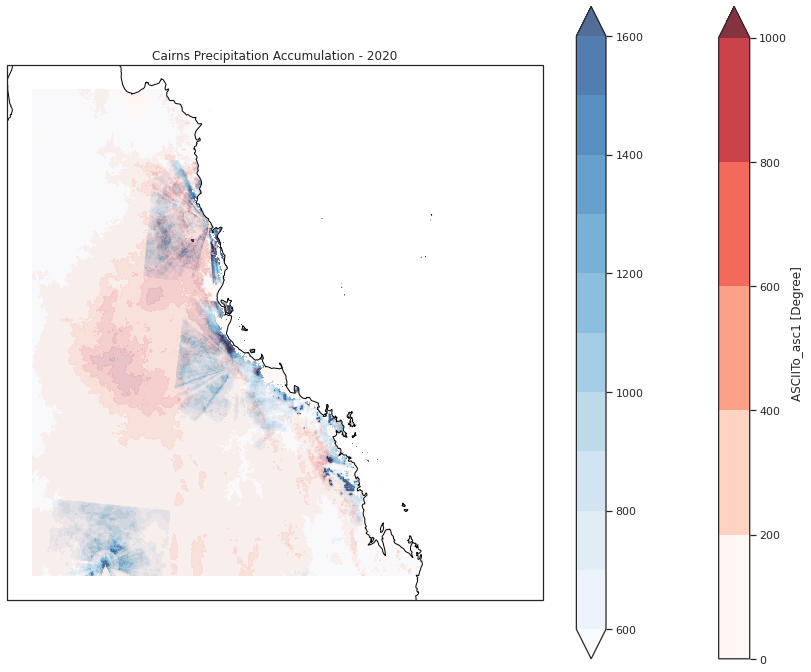

In [139]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj})
T15_topo.plot.contourf(levels=topo_levels,cmap='Reds',add_colorbar=True,ax=ax,add_labels=True,alpha=0.8)
T15_acc_mask_topo.plot(ax=ax,add_colorbar=True,cmap='Blues',
            levels=cmap_rf3.rainfall_levels_hr,alpha=0.7)
ax.coastlines('10m')
ax.set_title('Brisbane Precipitation Accumulation - 2020 < 20m')

### Scatterplot - Altitude Against Precipitation

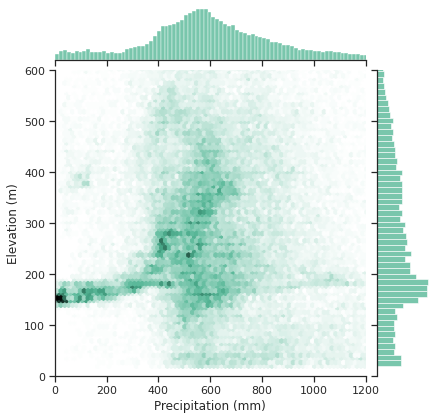

In [43]:
import seaborn as sns
sns.set_theme(style="ticks")

x = T15_acc_mask_topo.data.ravel()
y = T15_topo_mask.data.ravel()

plot = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",dropna=True,xlim=(0,1200),ylim=(0,600),gridsize=(100,50),hue_norm()
plot.ax_joint.set_ylabel('Elevation (m)')
plot.ax_joint.set_xlabel('Precipitation (mm)')
 
plt.show()

### Scatterplot - Zooming In on Gold Coast Mountains

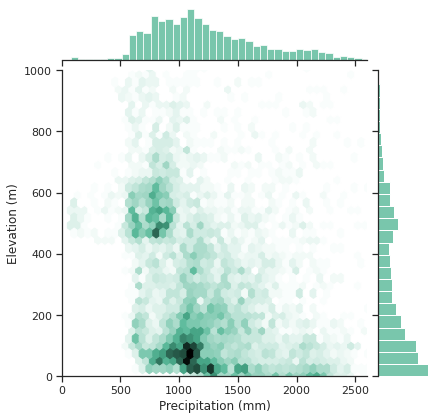

In [36]:
import seaborn as sns
sns.set_theme(style="ticks")

x = to_plot.precipitation.data.ravel()
y = to_plot_topo.data.ravel()

plot = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",dropna=True,xlim=(0,2600),ylim=(0,1000),gridsize=(50,25))
plot.ax_joint.set_ylabel('Elevation (m)')
plot.ax_joint.set_xlabel('Precipitation (mm)')
 
plt.show()

#### Above 20m

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")

x = to_plot_mask.data.ravel()
y = to_plot_topo_mask.data.ravel()

plot = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",dropna=True,xlim=(0,2600),ylim=(0,1000),gridsize=(50,25))
plot.ax_joint.set_ylabel('Elevation (m)')
plot.ax_joint.set_xlabel('Precipitation (mm)')
 
plt.show()

## Using Events Instead of Accumulation

In [27]:
T15_mask = xr.where(T15_fix.precipitation == 0, math.nan, T15_fix.precipitation  )

##### Change value following "T15_topo > "

In [28]:
T15_mask_topo = xr.where(T15_topo > 20 , T15_fix.precipitation, np.nan)

In [29]:
T15_topo_mask =  xr.where(T15_topo >20 , T15_topo, np.nan)

In [30]:
T15_mask_topo_precip = xr.where(T15_mask_topo > 0, T15_mask_topo, np.nan)

In [31]:
T15_mask_topo_precip

<xarray.DataArray (y: 512, x: 512, valid_time: 2386)>
dask.array<where, shape=(512, 512, 2386), dtype=float32, chunksize=(512, 512, 1), chunktype=numpy.ndarray>
Coordinates:
    lon         (y, x) float64 147.7 147.7 147.8 147.8 ... 156.2 156.2 156.3
    lat         (y, x) float64 -30.5 -30.5 -30.49 ... -20.06 -20.06 -20.05
  * x           (x) float64 1.489e+06 1.491e+06 ... 2.509e+06 2.511e+06
  * y           (y) float64 -3.411e+06 -3.409e+06 ... -2.391e+06 -2.389e+06
  * valid_time  (valid_time) datetime64[ns] 2020-01-09T08:00:00 ... 2020-12-3...

In [32]:
T15_test_prcp=T15_mask_topo_precip.isel(valid_time=slice(100,199))

In [33]:
num_repeats = 100
T15_test_topo = np.dstack([T15_topo_mask]*num_repeats)

In [34]:
T15_prcp_test = xr.where(T15_test_prcp==0, np.nan, T15_test_prcp)

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")

x = T15_prcp_test.values.flatten()
y = T15_test_topo.flatten()

plot = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",dropna=True,xlim=(0,10),hue_norm=(0,2))
plot.ax_joint.set_ylabel('Elevation (m)')
plot.ax_joint.set_xlabel('Precipitation (mm)')
 
plt.show()
plt.show()

## Diurnal Cycle

In [67]:
T15_mean = T15_fix.precipitation.mean(['x','y'])

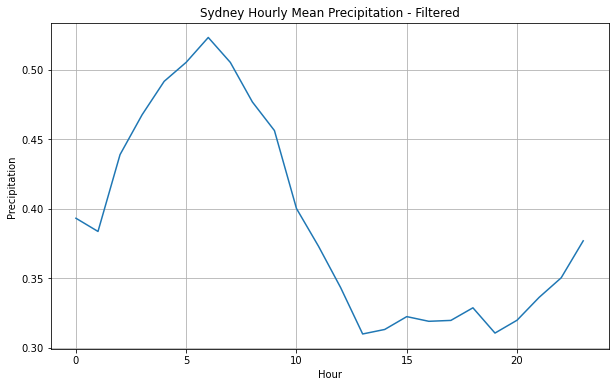

In [72]:
fig,ax=plt.subplots(figsize=(10,6))
T15_mean.groupby('valid_time.hour').mean().plot(ax=ax,label='Sydney')
ax.set_title('Brisbane Hourly Mean Precipitation - Filtered')
ax.set_xlabel('Hour')
ax.set_ylabel('Precipitation')
ax.grid(linestyle='-')

### Further Filtering by Altitude

In [62]:
T15_fix_mask_topo = xr.where(T15_topo < 20 , T15_fix.precipitation, np.nan)

In [63]:
T15_mean = T15_fix_mask_topo.mean(['x','y'])

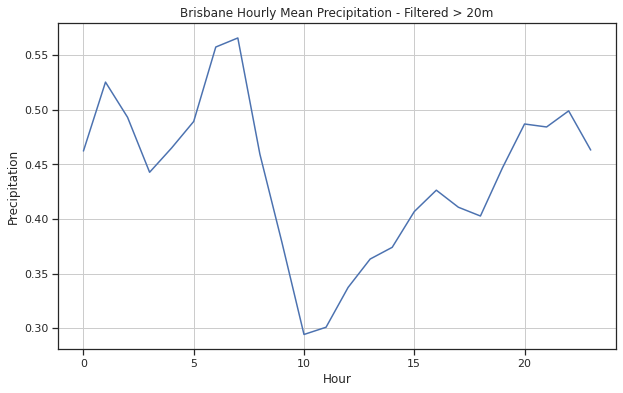

In [ ]:
fig,ax=plt.subplots(figsize=(10,6))
T15_mean.groupby('valid_time.hour').mean().plot(ax=ax,label='Cairns')
ax.set_title('Brisbane Hourly Mean Precipitation - Filtered > 20m')
ax.set_xlabel('Hour')
ax.set_ylabel('Precipitation')
ax.grid(linestyle='-')

## Identifying

In [ ]:
fig,ax=plt.subplots(figsize=(10,6))
T15_mean.plot(ax=ax,label='Brisbane')
ax.set_title('Brisbane Hourly Mean Precipitation - Filtered > 20m')
ax.set_xlabel('Hour')
ax.set_ylabel('Precipitation')
ax.grid(linestyle='-')